# Section2 Project

### 1. 목표

현재는 코로나 시기라서 여행산업이 불경기이고 여행에 대한 수요도 코로나 사태 전보다 적다. 하지만 코로나 바이러스 유행기는 언젠간 끝날 것이고 <br>그 시기에 여행에 대한 수요는 폭발할 것으로 예상된다. 여행은 숙소와 땔래야 땔 수 없는 관계인데, 숙박업의 경우 공실이 생기면 그만큼 손해가 발생하는 것이기 <br>때문에 공실을 최대한 줄여야한다.
이와 관련하여 "케이스별 호텔 예약 취소"를 예상하는 모델과 취소를 줄이려면 어떻게 해야하는 지 알아 볼 것이다. 

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 데이터 전처리

In [4]:
# 데이터 전처리
import numpy as np
import pandas as pd

hotel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hotel_bookings.csv')

print('중복데이터 수: ', hotel_df.duplicated().sum())
print(hotel_df.isnull().sum())

중복데이터 수:  31994
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340


In [5]:
# 결측치의 경우 Feature engineering 할 때, 특성 별로 정리하고 Simple imputer로 처리
# 중복값은 제거
hotel_df.drop_duplicates(inplace=True)

#### 데이터 프로파일링

In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(hotel_df, minimal=True)

profile

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

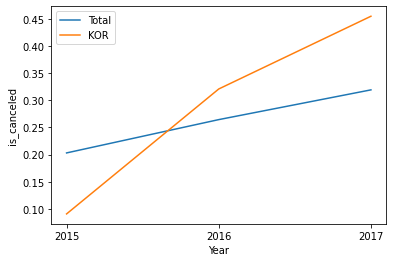

In [7]:
# 우선 받아온 Data를 먼저 분석해본다.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

total_mean = hotel_df.groupby('arrival_date_year').is_canceled.mean()

KOR_mean = hotel_df[hotel_df['country'] == 'KOR'].groupby('arrival_date_year').is_canceled.mean()

plt.plot(total_mean.index, total_mean, KOR_mean.index, KOR_mean)
plt.xlabel('Year')
plt.ylabel('is_canceled')
plt.xticks([2015, 2016, 2017])
plt.legend(['Total', 'KOR'])
plt.show()
# plt.savefig(fname='KOR_plot.png', dpi=144)

한국은 2015년도에는 전체 평균에 비해 취소율이 낮았지만, 2016년, 2017년에는 전체 평균에 비해 예약취소율이 높다. 전체 평균도 점점 상승하는 추세이긴 하지만 한국의 상승도는 많이 높다. 전체 평균이 상승했다는 것은 거의 모든 나라가 상승했다는 뜻이기도 하다.  

#### 데이터 split and Feature engineering

In [8]:
# train, val, test로 나눠주기
from sklearn.model_selection import train_test_split

target= 'is_canceled'


test = hotel_df[hotel_df['arrival_date_year'] == 2016]
test = test[test['arrival_date_week_number'] > 33]

train = hotel_df.drop(test.index, axis=0)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((56240, 32), (14060, 32), (17096, 32))

In [9]:
# 간단한 Feature engineering(요정도 했는데 성능이 잘나오는걸로 봐서 기존의 data가 좋은건가...)
def engineer(df):
  
  # 일단 High correlation의 Feature는 지워준다. 예측모델에 과적합을 일으킬 가능성이 높다. 결측치 10만개 넘어가는 놈도 지운다.
  # reservation_status_date는 cardinality가 높고, 대체가능한 feature가 많으니 지운다.
  df.drop(columns=['reservation_status', 'company', 'reservation_status_date'], inplace=True)
  
  # country가 예약취소에 영향을 끼친다고 생각하지 않기 때문에 없애버림.
  df.drop('country', axis=1, inplace=True)

  # children의 missing value는 0으로 채운다. 애가 있는지 없는지 모르면 없는거지 뭐.....
  df['children'].fillna(0, inplace=True)

  # agent를 끼지않은 경우 Nan으로 처리됐으니 0으로 채운다.
  df['agent'].fillna(0, inplace=True)

  # children, adults, babies를 합쳐 family라는 feature를 만들어준다.
  df['family'] = df['adults'] + df['children'] + df['babies']

  # 방 한개에 10명 넘게 들어갈 일이 없으므로 10명이상이면 예약할 때 실수 한 것으로 보고 없애버린다.
  df.drop(df[df['family'] > 9].index, axis=0, inplace=True)
  
  # 일 평균 이용금액이 0인 경우 이상치로 간주하고 삭제
  df.drop(df[df['adr'] == 0].index, axis=0, inplace=True)
  
  # 연도에 관한 Feature는 예측모델에 쓸만한 Feature가 아니므로 삭제(data split에만 사용)
  df.drop('arrival_date_year', axis=1, inplace=True)
  
  # 예약한 방과 실제 배정받은 방이 다른지 여부에 대한 Feature를 만들어줌
  room_change_df = df[['reserved_room_type', 'assigned_room_type']]
  room_change_df = room_change_df.reset_index()
  room_change_df.drop('index', axis=1, inplace=True)
  change_idx = []

  for i in range(len(df)):
    if room_change_df['reserved_room_type'][i] == room_change_df['assigned_room_type'][i]:
      change_idx.append(1)
    elif room_change_df['reserved_room_type'][i] != room_change_df['assigned_room_type'][i]:
      change_idx.append(0)

  df['room_change'] = change_idx

  # 이전 실제 이용 수 보다 이전 취소 수가 더 많은 케이스 관리를 위해 blacklist 생성
  blacklist_idx = []

  for i in ((df['previous_bookings_not_canceled'] - df['previous_cancellations']) < 0):
    if i == False:
      blacklist_idx.append(0)
    else:
      blacklist_idx.append(1)
  df['blacklist'] = blacklist_idx
  
  return df

engineer(train)
engineer(val)
engineer(test)

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,room_change,blacklist
7545,Resort Hotel,1,12,August,34,14,1,0,2,0.0,0,BB,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0.0,0,Transient,197.10,0,0,2.0,1,0
7546,Resort Hotel,1,60,August,34,14,1,0,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,189.00,0,0,2.0,1,0
7547,Resort Hotel,1,3,August,34,14,2,0,2,0.0,0,HB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,241.00,0,0,2.0,1,0
7548,Resort Hotel,1,49,August,34,14,2,2,2,0.0,0,BB,Online TA,TA/TO,0,0,0,C,C,0,No Deposit,241.0,0,Transient,230.00,0,0,2.0,1,0
7549,Resort Hotel,1,123,August,34,14,2,3,2,0.0,0,BB,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,0,Transient,216.00,0,2,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104139,City Hotel,0,173,December,53,26,3,8,2,1.0,0,BB,Direct,Direct,0,0,0,E,F,4,No Deposit,0.0,0,Transient,117.82,0,1,3.0,0,0
104142,City Hotel,0,17,December,53,30,2,5,2,0.0,0,SC,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,0,Transient,90.34,0,1,2.0,1,0
104145,City Hotel,0,177,December,53,30,2,5,0,0.0,0,BB,Direct,Direct,0,0,0,E,K,2,No Deposit,0.0,0,Transient,1.29,0,2,0.0,0,0
104147,City Hotel,0,107,December,53,31,2,5,2,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,B,0,No Deposit,28.0,0,Transient,103.57,0,0,2.0,0,0


In [10]:
# Ordinal Encoder mapping 해줘야할 Feature를 정해준다.

ord_feature = ['deposit_type', 'meal', 'arrival_date_month']

ord_mapping = [
    {'col' : 'deposit_type',
    'mapping' : {
        'No Deposit' : 0,
        'Refundable' : 1,
        'Non Refund' : 2,
        }},
    {'col' : 'meal',
    'mapping' : {
        'SC' : 0,
        'BB' : 1,
        'HB' : 2,
        'FB' : 3,
        'Undefined' : 0,
        }},
        {'col' : 'arrival_date_month',
        'mapping' : {
            'January' : 1, 'February' : 2, 'March' : 3,
            'April' : 4, 'May' : 5, 'June' : 6, 
            'July' : 7, 'October' : 8, 'September' : 9,
            'August' : 10, 'November' : 11, 'December' : 12
            }}]



# 다른 categorical(string) Feature들은 Label encoder를 사용해서 바꿔준다.

cat_feature = ['hotel', 'market_segment', 'distribution_channel', 'reserved_room_type',
               'assigned_room_type', 'customer_type']

In [11]:
target = 'is_canceled' 
features = train.columns.drop('is_canceled')

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [12]:
# 분류모델이므로 기준모델은 target의 최빈값으로 accuracy 구해야함.

# 우선 target 비율을 보고 불균형모델인지 균형모델인지 알아봄.
train[target].value_counts(normalize=True)

0    0.725034
1    0.274966
Name: is_canceled, dtype: float64

In [13]:
# 기준모델 구하기
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print("training accuracy: ", accuracy_score(y_train, y_pred))

training accuracy:  0.7250335789741169


In [14]:
# 검증세트에서도 정확도를 확인.
y_val = val[target]
y_pred = [major] * len(y_val)
print("validation accuracy: ", accuracy_score(y_val, y_pred))

validation accuracy:  0.7247839663060054


#### 학습모델 만들기

In [15]:
# 불균형 모델이므로 ratio 적용
ratio = 0.73/0.27

In [16]:
# XGboost, ordinalencoder, Catboostencoder 사용

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from category_encoders import CatBoostEncoder
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(ord_mapping),
    CatBoostEncoder(cols=cat_feature),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2,
                  scale_pos_weight=ratio
                 )
)

pipe.fit(X_train, y_train);

In [17]:
# 모델의 훈련정확도 확인, 교차검증으로 데이터가 잘 나뉜건지 확인
from sklearn.metrics import classification_report
y_train_pred = pipe.predict(X_train)
print('훈련 정확도: ', accuracy_score(y_train, y_train_pred))
print(classification_report(y_train_pred, y_train))

훈련 정확도:  0.8186916905652158
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     35628
           1       0.81      0.63      0.71     19466

    accuracy                           0.82     55094
   macro avg       0.82      0.78      0.79     55094
weighted avg       0.82      0.82      0.81     55094



In [18]:
# 모델의 검증정확도 확인, 교차검증으로 데이터가 잘 나뉜건지 확인
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print(classification_report(y_pred, y_val))

검증 정확도:  0.7932612010747222
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      8914
           1       0.77      0.60      0.67      4857

    accuracy                           0.79     13771
   macro avg       0.78      0.75      0.76     13771
weighted avg       0.79      0.79      0.79     13771



In [19]:
from sklearn.metrics import roc_auc_score
print('ROC/AUC 검증점수:' ,roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1]))

ROC/AUC 검증점수: 0.8688833718101332


훈련 정확도와 검증 정확도 둘다 기준모델보다 높다. 따라서 학습이 잘된 데이터라고 할 수 있다. 훈련 정확도와 검증 정확도의 차이가 얼마 안나는 것으로 봐선 과적합이나 과소적합도 일어나지 않은 것으로 보인다.

ROC/AUC 검증점수 또한 0.87로 높다.

In [20]:
# 그래도 혹시 모르니 randomforest를 진행해본다.
from sklearn.ensemble import RandomForestClassifier
pipe_rf = make_pipeline(
    OrdinalEncoder(ord_mapping),
    CatBoostEncoder(cols=cat_feature),
    RandomForestClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1))

pipe_rf.fit(X_train, y_train);

In [21]:
# 모델의 검증정확도 확인, 교차검증으로 데이터가 잘 나뉜건지 확인
y_pred = pipe_rf.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print(classification_report(y_pred, y_val))

검증 정확도:  0.8257933338174425
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     11106
           1       0.54      0.76      0.63      2665

    accuracy                           0.83     13771
   macro avg       0.74      0.80      0.76     13771
weighted avg       0.86      0.83      0.84     13771



In [23]:
from sklearn.metrics import roc_auc_score
print('ROC/AUC 검증점수:' ,roc_auc_score(y_val, pipe_rf.predict_proba(X_val)[:, 1]))

ROC/AUC 검증점수: 0.8717572622811837


엥 randomforest로 진행한 것이 교차검증이랑 검증 정확도도 더 높다. 큰일이다 혹시 몰라서 해본건데... <br>그럼 randomsearchCV로 하이퍼파라미터 튜닝해봐야겠다.

In [28]:
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipe_rf = make_pipeline(
    OrdinalEncoder(ord_mapping),
    CatBoostEncoder(cols=cat_feature),
    RandomForestClassifier(random_state=2))

dists = {
    
    'randomforestclassifier__n_estimators': randint(100, 1000), 
    'randomforestclassifier__max_depth': [5, 7, 9, 10], 
    'randomforestclassifier__min_samples_leaf': [1, 3, 5],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__class_weight' : ['balanced', None]
}

clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 64.9min finished


In [29]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,8,29,17,1,30,12,18,38,46,36,37,40,11,3,31,43,6,13,14,28,49,42,20,44,47,34,2,4,21,41,5,25,7,48,45,24,15,19,26,9,16,35,33,27,0,39,32,23,22,10
mean_fit_time,118.057,78.0082,31.6296,120.578,37.2805,44.9574,108.675,84.3395,34.6675,32.4309,53.4953,68.3747,31.6749,10.5095,27.8031,60.023,56.2104,77.9739,19.0536,65.5081,15.9737,37.9003,47.0483,29.903,40.8237,54.4717,52.4114,38.5888,16.5678,83.9419,67.1182,86.614,17.5071,97.3035,81.1369,77.6175,25.7429,78.9028,28.9366,69.7112,58.041,40.9834,38.4188,19.8697,24.836,13.0163,10.6576,12.6622,45.7837,35.8722
std_fit_time,0.547318,0.119177,0.302549,0.755484,0.11313,0.209789,0.185907,0.26094,0.0951344,0.108196,0.0743974,0.402996,0.110868,0.00827801,0.127358,0.205154,0.221658,0.387956,0.0529333,0.240037,0.0490156,0.151661,0.101539,0.141674,0.228924,0.201776,0.230598,0.112055,0.152162,0.275512,0.242377,0.163926,0.0219763,6.7351,0.172693,0.402583,0.18885,0.245329,0.112508,0.135624,0.13588,0.209928,0.0973587,0.0858941,0.037562,0.0417556,0.0355955,0.0438817,0.0112037,0.167518
mean_score_time,2.90301,1.83624,0.77653,2.75831,1.29048,1.09988,2.60558,1.98984,0.930832,0.837166,1.28504,1.61907,1.11672,0.43864,1.055,2.20978,1.42901,1.95573,0.563962,1.64726,0.694193,1.56399,1.36458,1.25579,1.68328,1.55805,1.52144,0.940648,0.455131,2.00902,1.55496,2.83461,0.712749,2.14066,2.05724,1.86243,0.932398,2.00935,0.800249,1.82354,1.57272,1.08541,1.42616,0.587007,1.03132,0.425689,0.460959,0.553592,1.34577,1.48519
std_score_time,0.198577,0.0472081,0.00825941,0.023216,0.0258006,0.0275753,0.0977704,0.00431558,0.0695808,0.019943,0.0243897,0.0340457,0.00907037,0.0126649,0.0124153,0.0569267,0.0153554,0.0213422,0.00360247,0.0304517,0.0110301,0.0244839,0.0135971,0.0275007,0.0464198,0.0145832,0.0206734,0.0228896,0.00601239,0.00962024,0.0254679,0.0582482,0.0358792,0.373744,0.121525,0.059757,0.0318413,0.0225721,0.000687423,0.0161438,0.042588,0.0175121,0.0454702,0.00756975,0.0724706,0.00838417,0.00939059,0.00979706,0.025288,0.0402206
param_randomforestclassifier__bootstrap,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True
param_randomforestclassifier__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
param_randomforestclassifier__max_depth,10,10,10,10,10,9,9,9,9,9,9,9,9,9,7,7,7,7,7,7,5,5,5,5,5,5,5,10,10,10,10,10,9,9,9,9,9,7,7,7,7,7,7,7,7,7,7,5,5,5
param_randomforestclassifier__min_samples_leaf,3,3,1,1,5,1,5,5,5,5,3,3,3,5,1,5,1,1,5,5,3,1,1,5,3,1,5,1,1,3,3,5,3,1,5,3,5,3,5,5,5,5,1,3,3,5,5,5,3,3
param_randomforestclassifier__min_samples_split,5,5,5,10,10,2,10,10,10,2,2,2,10,10,2,10,2,5,2,5,5,10,10,10,10,2,10,2,5,5,2,10,10,2,2,10,10,5,5,10,10,5,2,10,10,5,5,5,2,10
param_randomforestclassifier__n_estimators,899,588,233,919,412,368,904,697,281,263,439,564,379,117,403,900,578,798,186,671,298,732,646,570,788,747,719,295,121,655,525,979,204,869,692,661,304,838,300,738,614,430,563,202,359,127,143,230,646,695


In [30]:
pipe_rf = make_pipeline(
    OrdinalEncoder(ord_mapping),
    CatBoostEncoder(cols=cat_feature),
    RandomForestClassifier(n_estimators=899, bootstrap=False, class_weight='balanced'
                  , max_depth=10, min_samples_leaf=3, min_samples_split=5
                  , random_state=2
                  , n_jobs=-1))

pipe_rf.fit(X_train, y_train);

In [31]:
y_pred = pipe_rf.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print(classification_report(y_pred, y_val))
print('ROC/AUC 검증점수:' ,roc_auc_score(y_val, pipe_rf.predict_proba(X_val)[:, 1]))

검증 정확도:  0.7467141093602498
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      8007
           1       0.80      0.53      0.63      5764

    accuracy                           0.75     13771
   macro avg       0.76      0.72      0.72     13771
weighted avg       0.76      0.75      0.73     13771

ROC/AUC 검증점수: 0.8529236023378456


튜닝을 해주니 더 떨어졌다. 검증 정확도의 경우 baseline보다 더 안좋다. 검증점수 또한 더 떨어졌다. 효율적인 xgboost를 쓰자.

In [19]:
# 모델의 성능을 더 올리기위해 하이퍼파라미터 튜닝을 해준다.
processor = make_pipeline(
    OrdinalEncoder(ord_mapping),
    )

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)# 검증데이터



eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-auc:0.691448	validation_1-auc:0.690604
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.691966	validation_1-auc:0.691271
[2]	validation_0-auc:0.740595	validation_1-auc:0.74137
[3]	validation_0-auc:0.741293	validation_1-auc:0.742159
[4]	validation_0-auc:0.78055	validation_1-auc:0.785807
[5]	validation_0-auc:0.796865	validation_1-auc:0.80173
[6]	validation_0-auc:0.79774	validation_1-auc:0.803285
[7]	validation_0-auc:0.80275	validation_1-auc:0.809105
[8]	validation_0-auc:0.802226	validation_1-auc:0.80835
[9]	validation_0-auc:0.805018	validation_1-auc:0.811675
[10]	validation_0-auc:0.805627	validation_1-auc:0.812535
[11]	validation_0-auc:0.810978	validation_1-auc:0.816508
[12]	validation_0-auc:0.811627	validation_1-auc:0.816939
[13]	validation_0-auc:0.812126	validation_1-auc:0.816842
[14]	validation_0-auc:0.815231	validation_1-auc:0.819492
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.7037037037037033,
              seed=None, silent=None, subsample=1, verbosity=0)

In [20]:
pipe = make_pipeline(
    OrdinalEncoder(cols=ord_feature, mapping=ord_mapping),
    CatBoostEncoder(cols=cat_feature),
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, gamma=0,
                  learning_rate=0.1, max_delta_step=0, max_depth=3,
                  min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, seed=None, silent=None, subsample=1, 
                  verbosity=0, scale_pos_weight=ratio
                 )
)

pipe.fit(X_train, y_train);

In [21]:
y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_val)
print('훈련 정확도: ', accuracy_score(y_train, y_train_pred))
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print('ROC/AUC 검증점수:' ,roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1]))

훈련 정확도:  0.7844229861690928
검증 정확도:  0.7748166436714835
ROC/AUC 검증점수: 0.8673514506057552


하이퍼파라미터 튜닝을 진행하니 전보다 정확도가 낮아졌지만 그래도 기준모델보다는 높다. 검증점수도 0.001정도 차이밖에 보이지 않아서 test data를 위해서 걍 내비둔다.

#### 특성중요도, 순열중요도, PDP, SHAP 구하기

In [22]:
# 우선 pipe의 step이름을 알아본다.
pipe.named_steps

{'catboostencoder': CatBoostEncoder(a=1,
                 cols=['hotel', 'market_segment', 'distribution_channel',
                       'reserved_room_type', 'assigned_room_type',
                       'customer_type'],
                 drop_invariant=False, handle_missing='value',
                 handle_unknown='value', random_state=None, return_df=True,
                 sigma=None, verbose=0),
 'ordinalencoder': OrdinalEncoder(cols=['deposit_type', 'meal', 'arrival_date_month'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value',
                mapping=[{'col': 'deposit_type',
                          'mapping': {'No Deposit': 0, 'Non Refund': 2,
                                      'Refundable': 1}},
                         {'col': 'meal',
                          'mapping': {'BB': 1, 'FB': 3, 'HB': 2, 'SC': 0,
                                      'Undefined': 0}},
                         {'col': 'arrival_date_month',
    

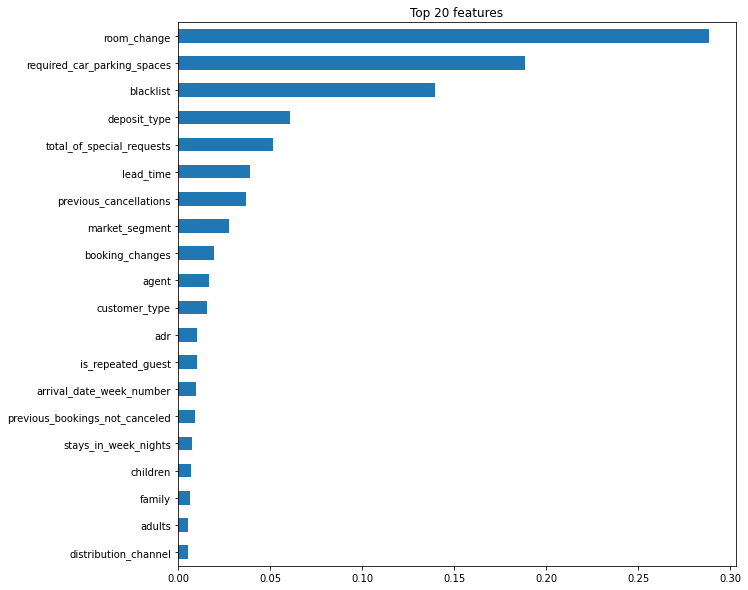

In [23]:
# 특성중요도가 어떤지 알아본다.

xgb = pipe.named_steps['xgbclassifier']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();
# plt.savefig(fname='Top 20 features.png', bbox_inches='tight', dpi=144);

In [25]:
# 순열 중요도를 알아본다.
# encoder, imputer를 preprocessing으로 묶음. 후에 eli5 permutation 계산에 사용함


from sklearn.pipeline import Pipeline
pipe = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(cols=ord_feature, mapping=ord_mapping),
                               CatBoostEncoder(cols=cat_feature))),
                 ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, gamma=0,
                  learning_rate=0.1, max_delta_step=0, max_depth=3,
                  min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, seed=None, silent=None, subsample=1, 
                  verbosity=0, scale_pos_weight=ratio
                 )) 
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['deposit_type', 'meal',
                                                       'arrival_date_month'],
                                                 drop_invariant=False,
                                                 handle_missing='value',
                                                 handle_unknown='value',
                                                 mapping=[{'col': 'deposit_type',
                                                           'mapping': {'No Deposit': 0,
                                                                       'Non Refund': 2,
                                                                       'Refundable': 1}},
                                                          {'col': 'meal',
                                                         

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xg'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업
permuter.fit(X_val_transformed, y_val);

In [27]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

distribution_channel             -0.002149
reserved_room_type               -0.001975
meal                             -0.001598
days_in_waiting_list             -0.000145
is_repeated_guest                 0.000189
children                          0.000479
babies                            0.000595
arrival_date_day_of_month         0.000973
assigned_room_type                0.001031
arrival_date_month                0.001075
stays_in_weekend_nights           0.001612
adults                            0.001670
previous_bookings_not_canceled    0.001801
hotel                             0.002614
market_segment                    0.002992
family                            0.003515
stays_in_week_nights              0.005519
arrival_date_week_number          0.005766
deposit_type                      0.006535
previous_cancellations            0.006652
blacklist                         0.006942
adr                               0.007291
booking_changes                   0.007770
customer_ty

In [28]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야함
)

Weight,Feature
0.0526 ± 0.0046,lead_time
0.0352 ± 0.0050,total_of_special_requests
0.0284 ± 0.0039,agent
0.0267 ± 0.0043,required_car_parking_spaces
0.0235 ± 0.0047,room_change
0.0141 ± 0.0037,customer_type
0.0078 ± 0.0024,booking_changes
0.0073 ± 0.0031,adr
0.0069 ± 0.0009,blacklist
0.0067 ± 0.0015,previous_cancellations


특성 중요도와 다르게 순열중요도에서는 lead_time, total_of_special_requests, agent 등이 높게 나왔다. 하지만 room_change의 경우 순열중요도에서도 높은 편에 속하는 것으로 나왔다. 중요도가 -로 나온 값들을 제거하고 학습시켜야겠다.

In [29]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [30]:
from sklearn.pipeline import Pipeline
pipe_per = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(cols=['deposit_type', 'arrival_date_month'], 
                                                                mapping=
    [{'col' : 'deposit_type',
    'mapping' : {
        'No Deposit' : 0,
        'Refundable' : 1,
        'Non Refund' : 2,
        }},
        
        {'col' : 'arrival_date_month',
        'mapping' : {
            'January' : 1, 'February' : 2, 'March' : 3,
            'April' : 4, 'May' : 5, 'June' : 6, 
            'July' : 7, 'October' : 8, 'September' : 9,
            'August' : 10, 'November' : 11, 'December' : 12
            }}]),
                               CatBoostEncoder())),
                 ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, gamma=0,
                  learning_rate=0.1, max_delta_step=0, max_depth=3,
                  min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, seed=None, silent=None, subsample=1, 
                  verbosity=0, scale_pos_weight=ratio
                 )) 
], verbose=1)

pipe_per.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.4s
[Pipeline] ................ (step 2 of 2) Processing xg, total=  38.1s


In [31]:
print('검증 정확도: ', pipe_per.score(X_val_selected, y_val))

검증 정확도:  0.7698061142981628


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


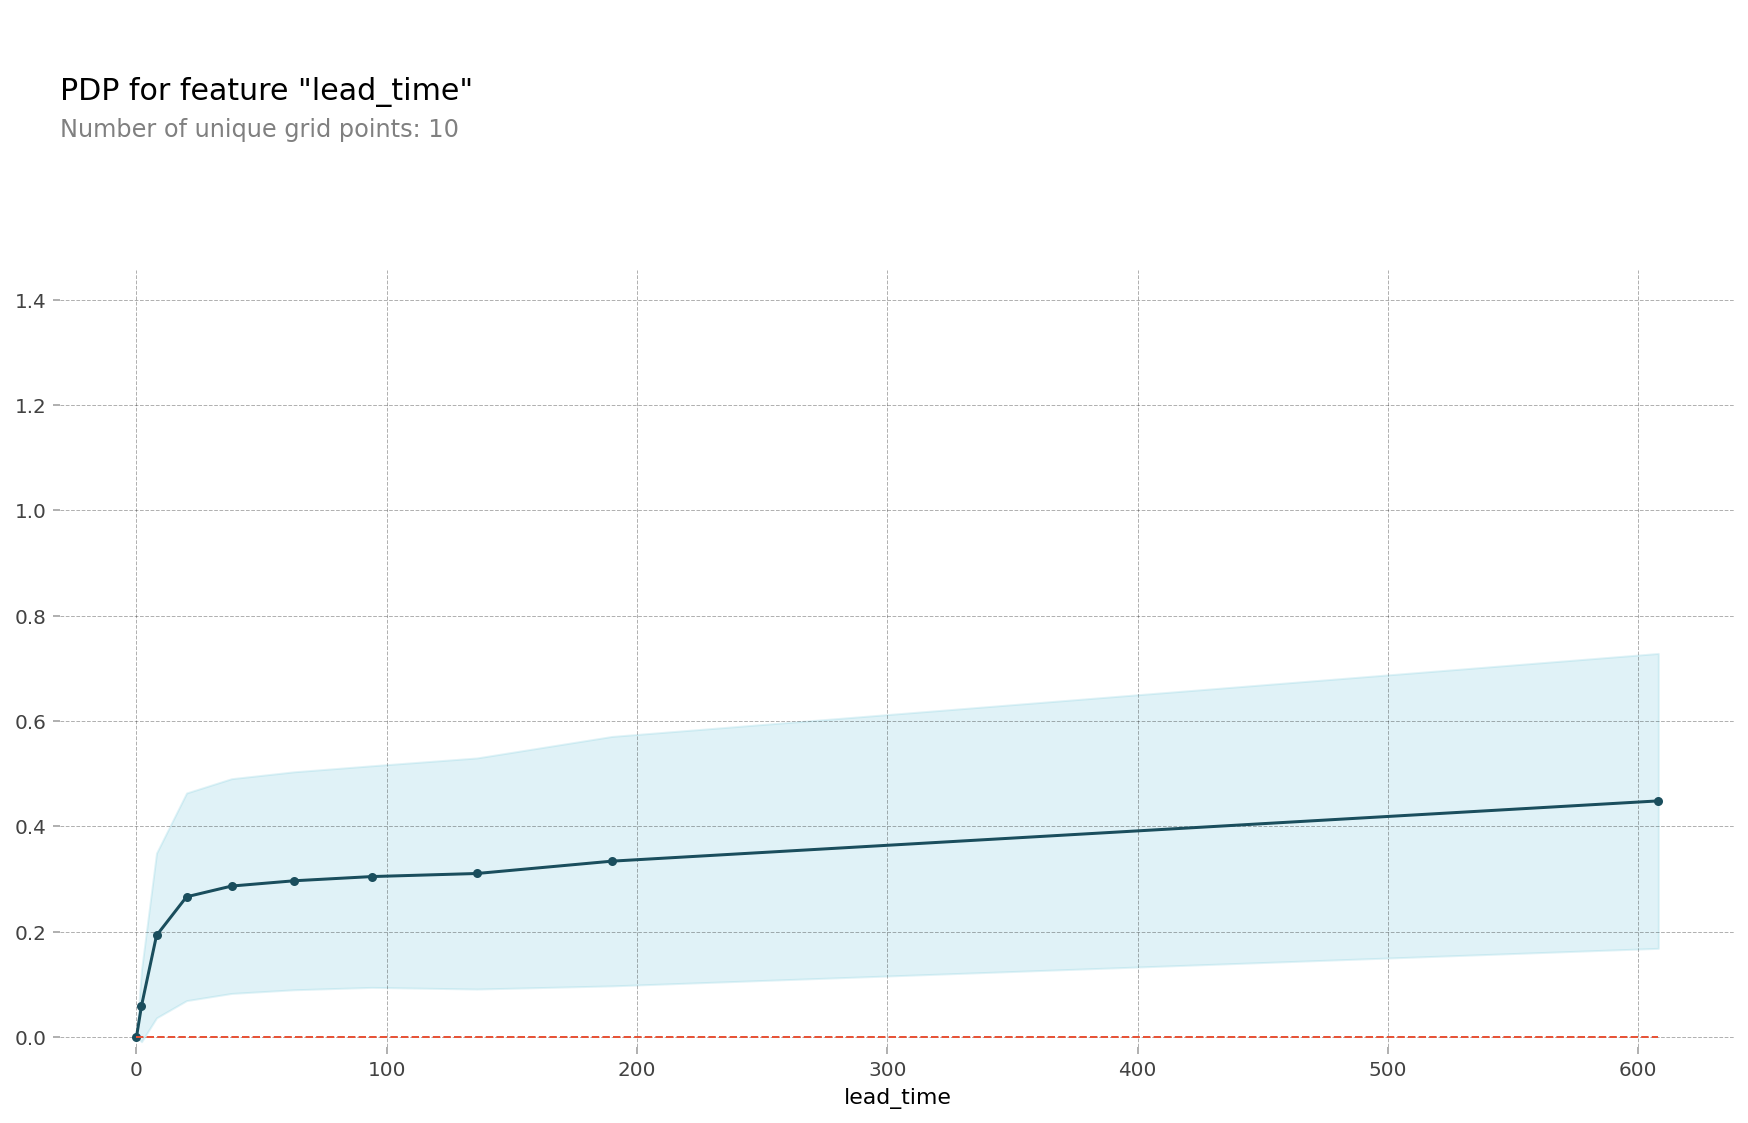

In [32]:
# 순열중요도가 높게 나온 Feature PDP 보기
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'lead_time'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)
plt.savefig(fname='PDP_1.png')

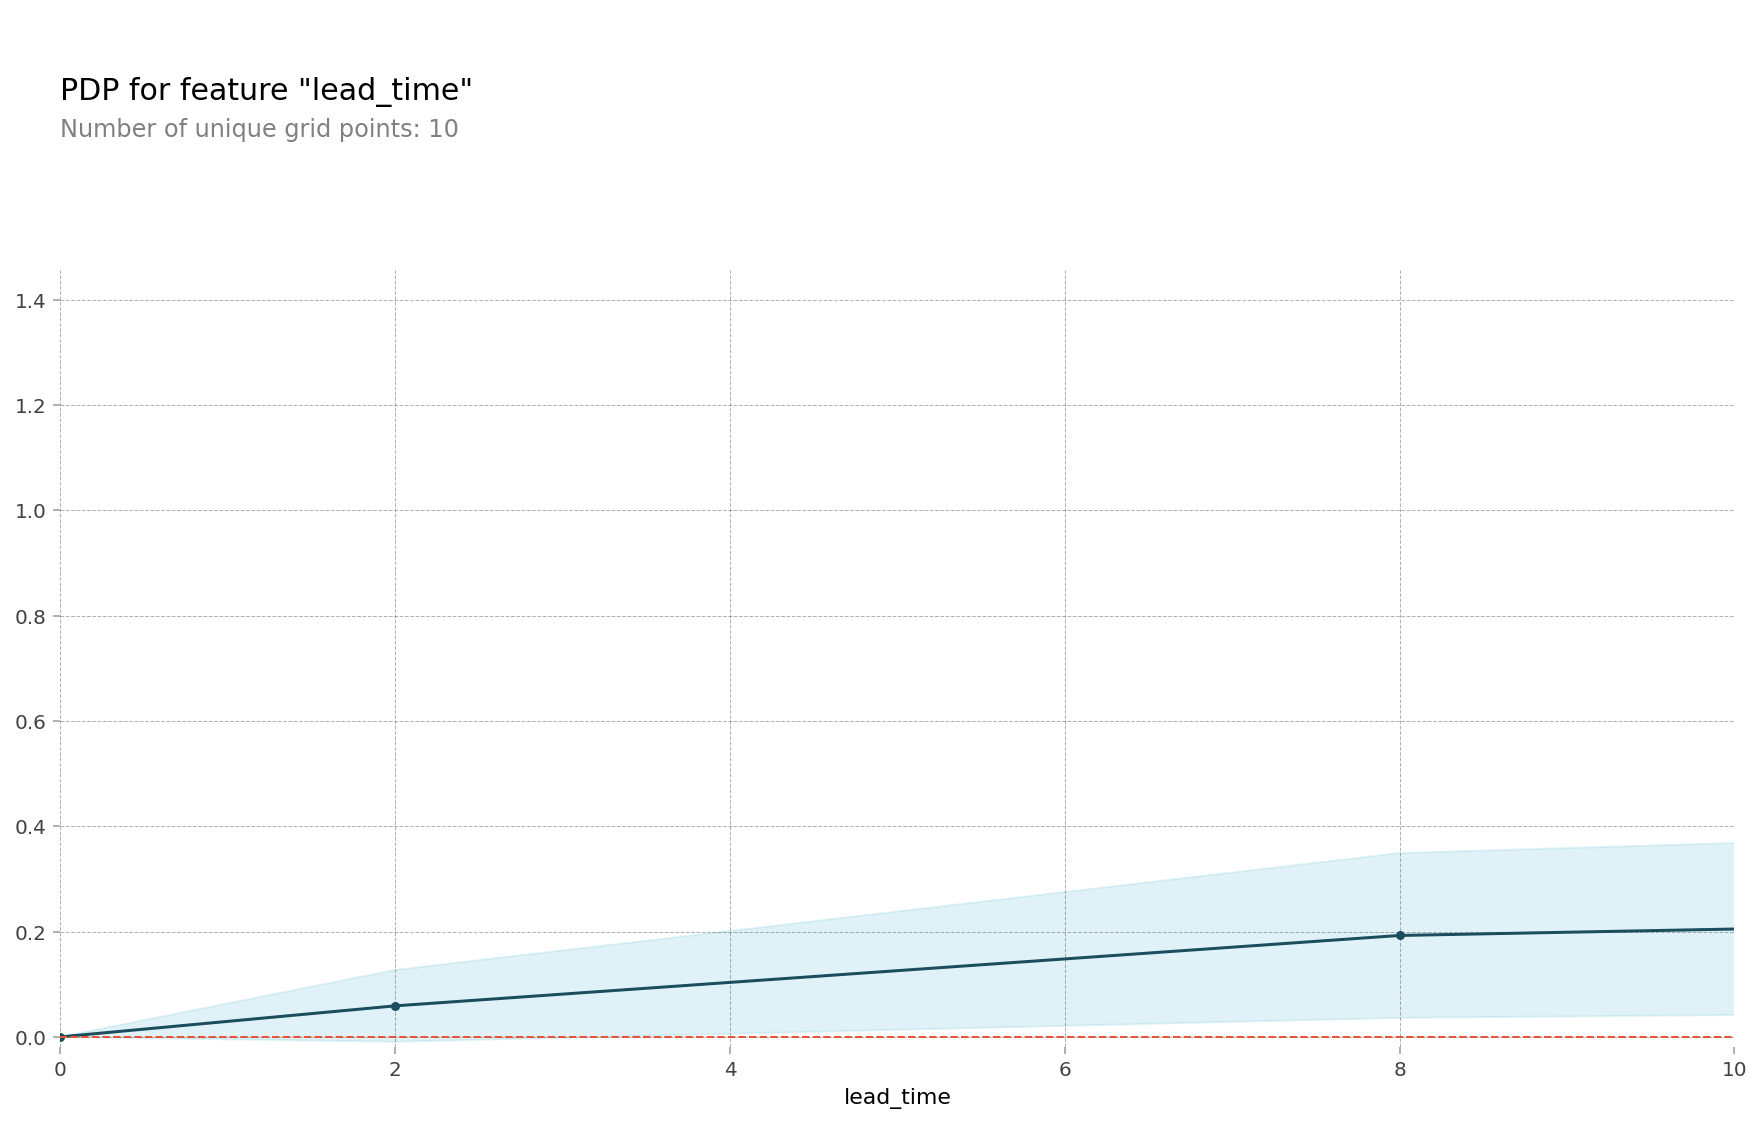

In [33]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((0,10))
plt.savefig(fname='PDP_2.png');

lead time이 8정도에서 0.2로 높아 졌다가, 0.4까지 완만하게 올라가는 것을 볼 수 있다.

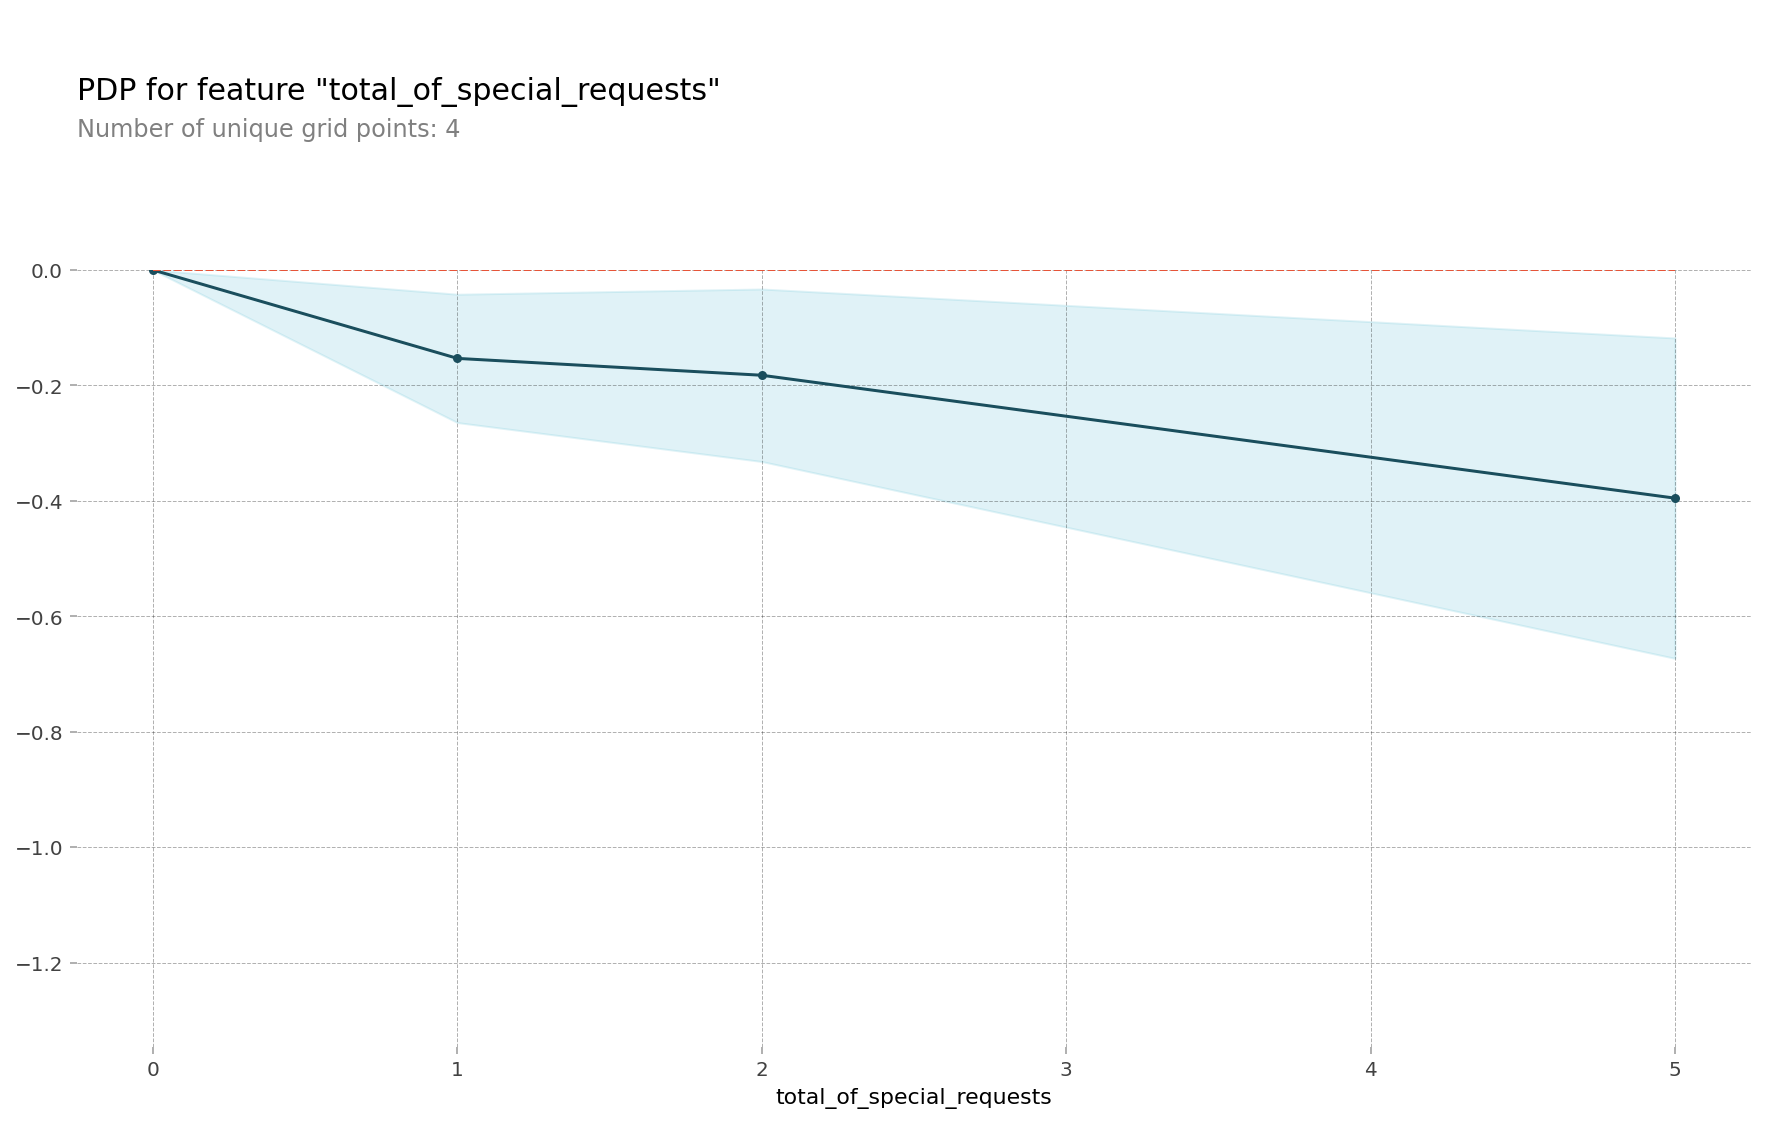

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'total_of_special_requests'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)
plt.savefig(fname='PDP_3.png');

total_of_special_requests의 값이 높을수록 취소 정도는 낮아지는 것을 볼 수 있다. 예약 취소를 줄이려면 total_of_special_requests를 높여야하지만 이 값은 손님이 요구하는 사항이라 호텔에서 조절하기는 힘들다. 

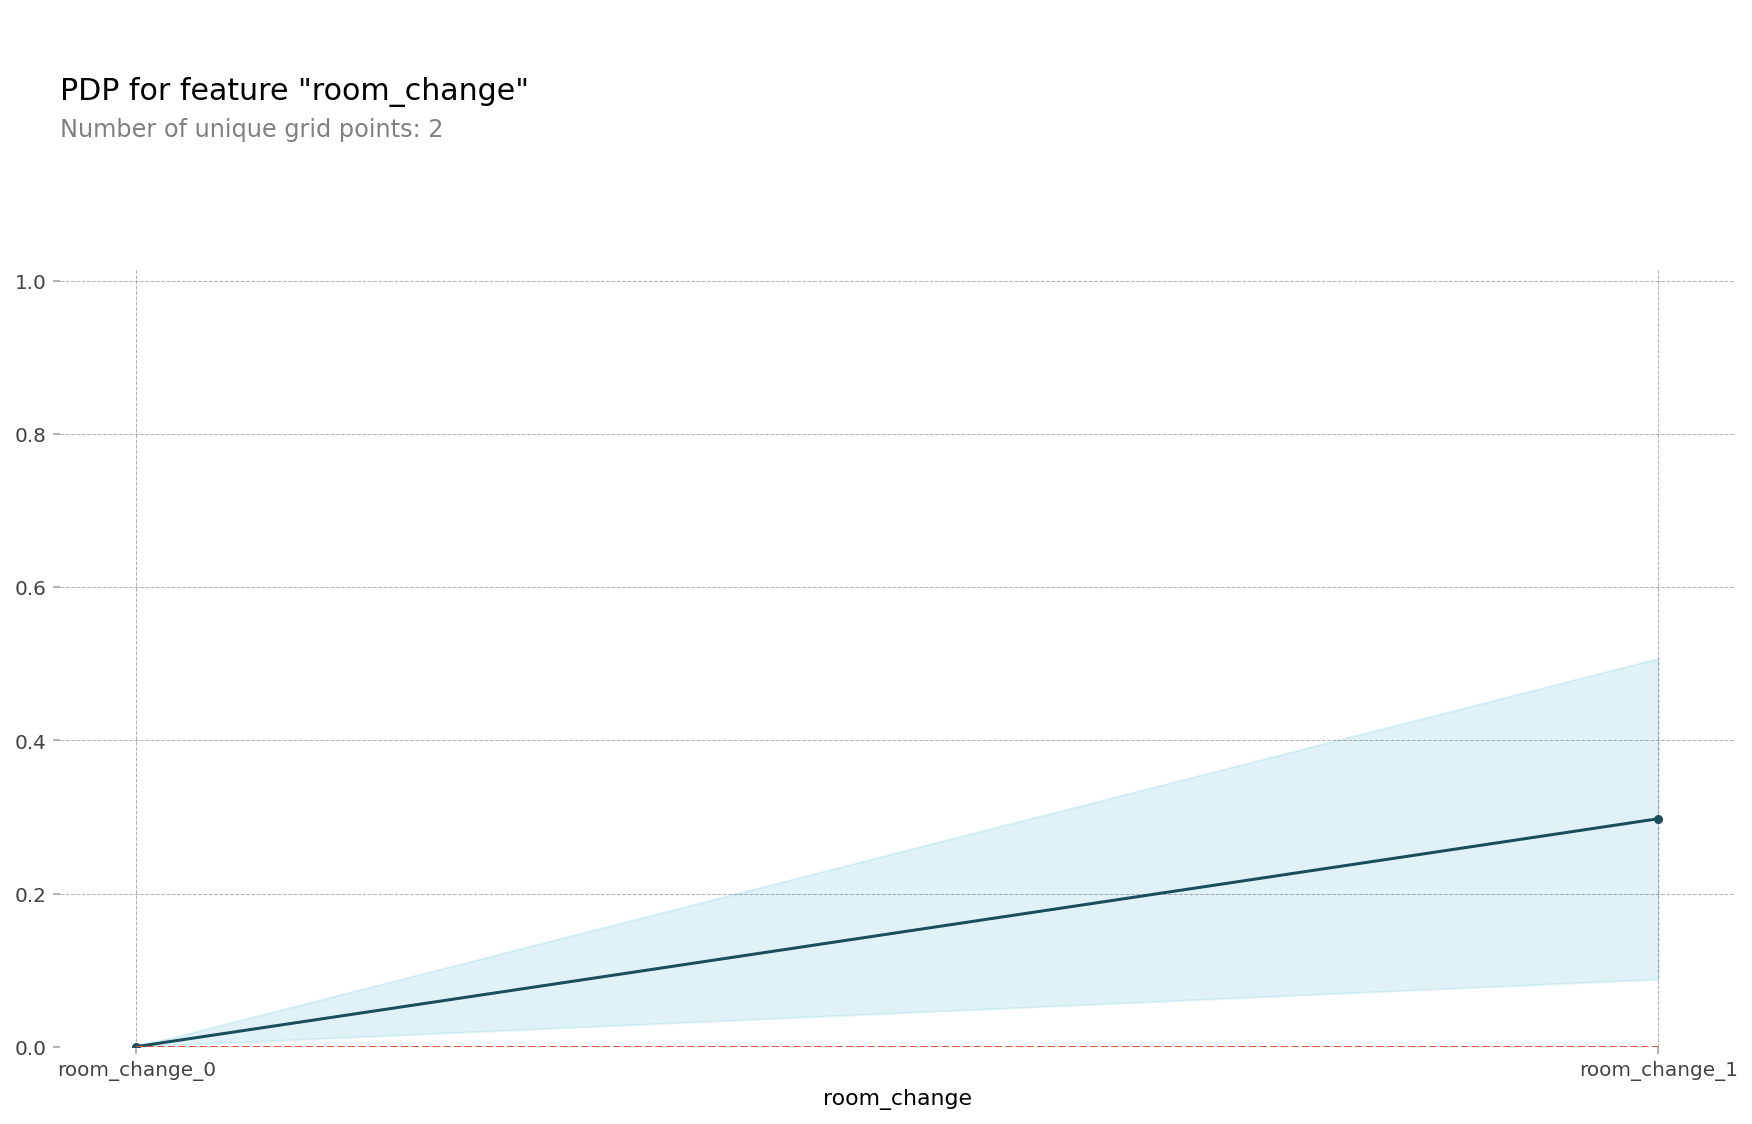

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'room_change'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)
plt.savefig(fname='PDP_4.png');

room_change는 처음 예약한 방과 실제로 배정받은 방이 다른지 여부에 대한 Feature인데 예약한 방과 다른 방을 배정받으면 취소정도가 높아지는 것을 볼 수 있다. 예약취소를 줄이려면 최대한 예약받은 방과 같은 방을 줘야할 것으로 예상한다.

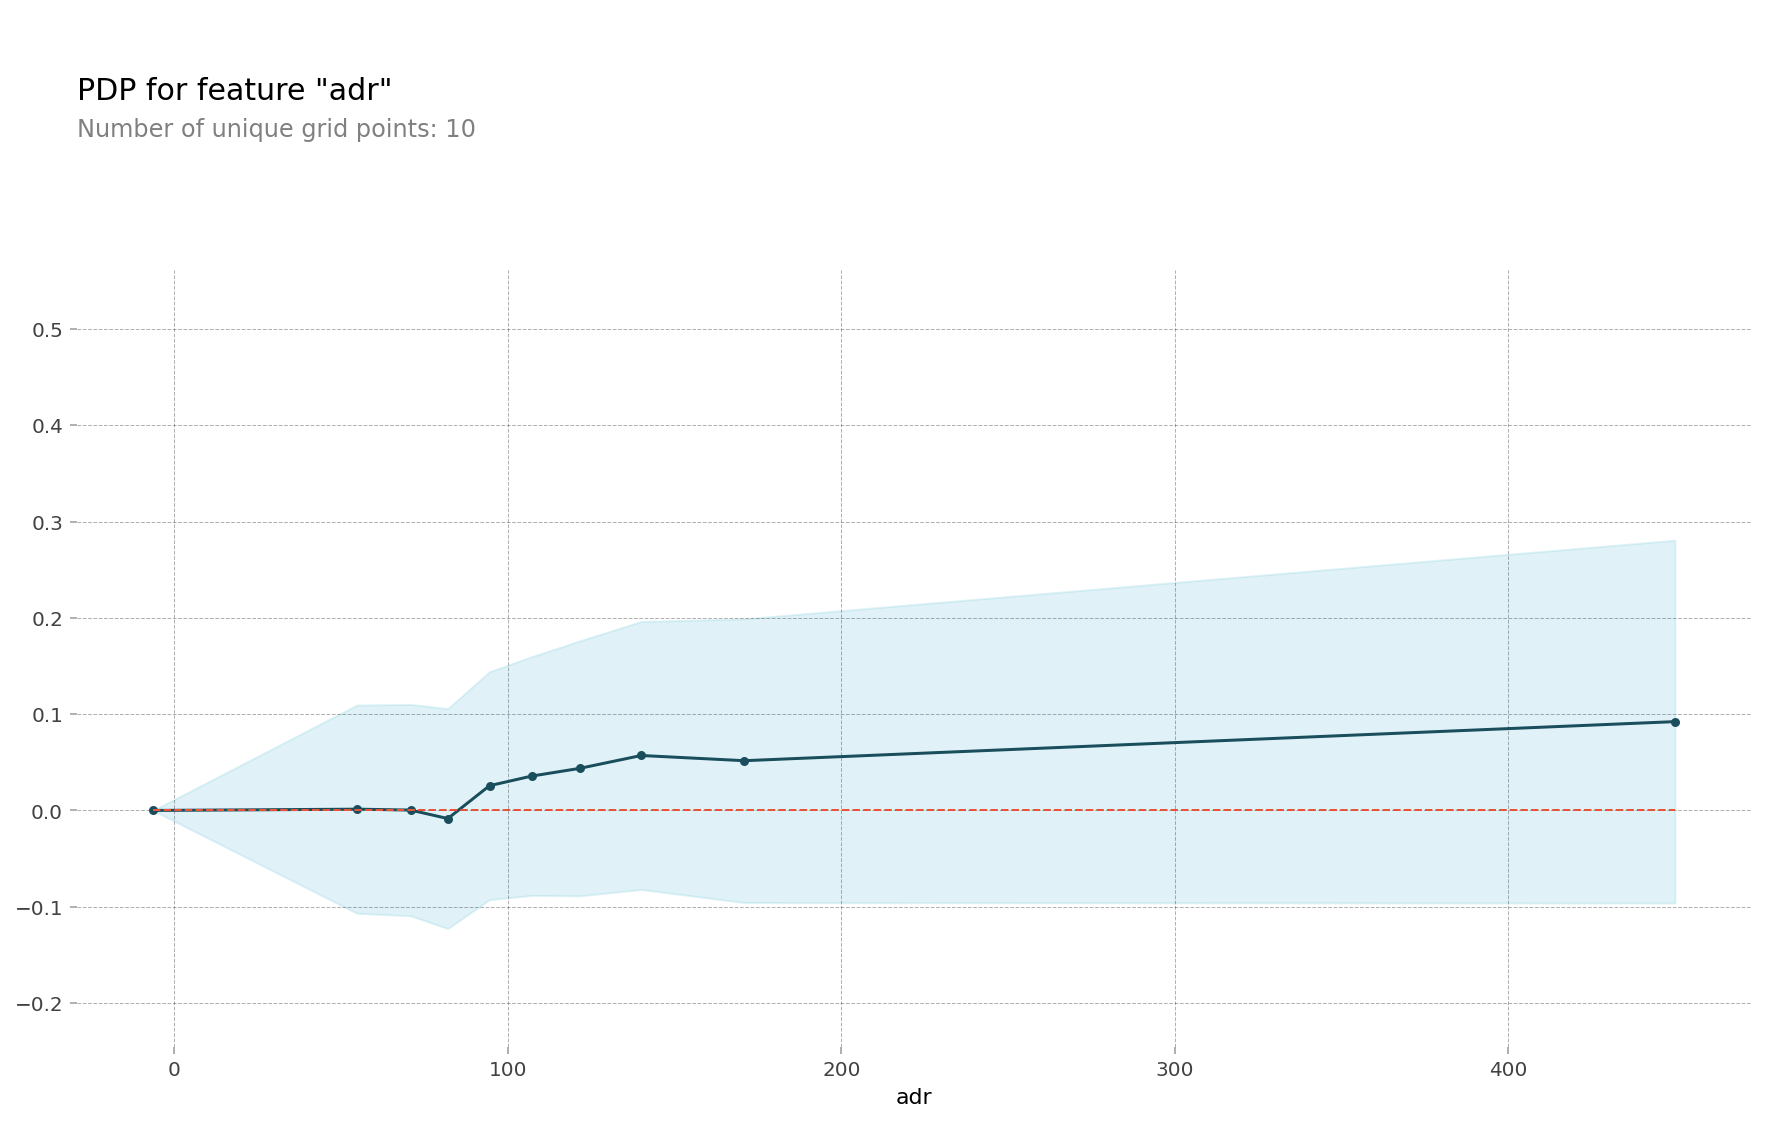

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'adr'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)
plt.savefig(fname='PDP_5.png');

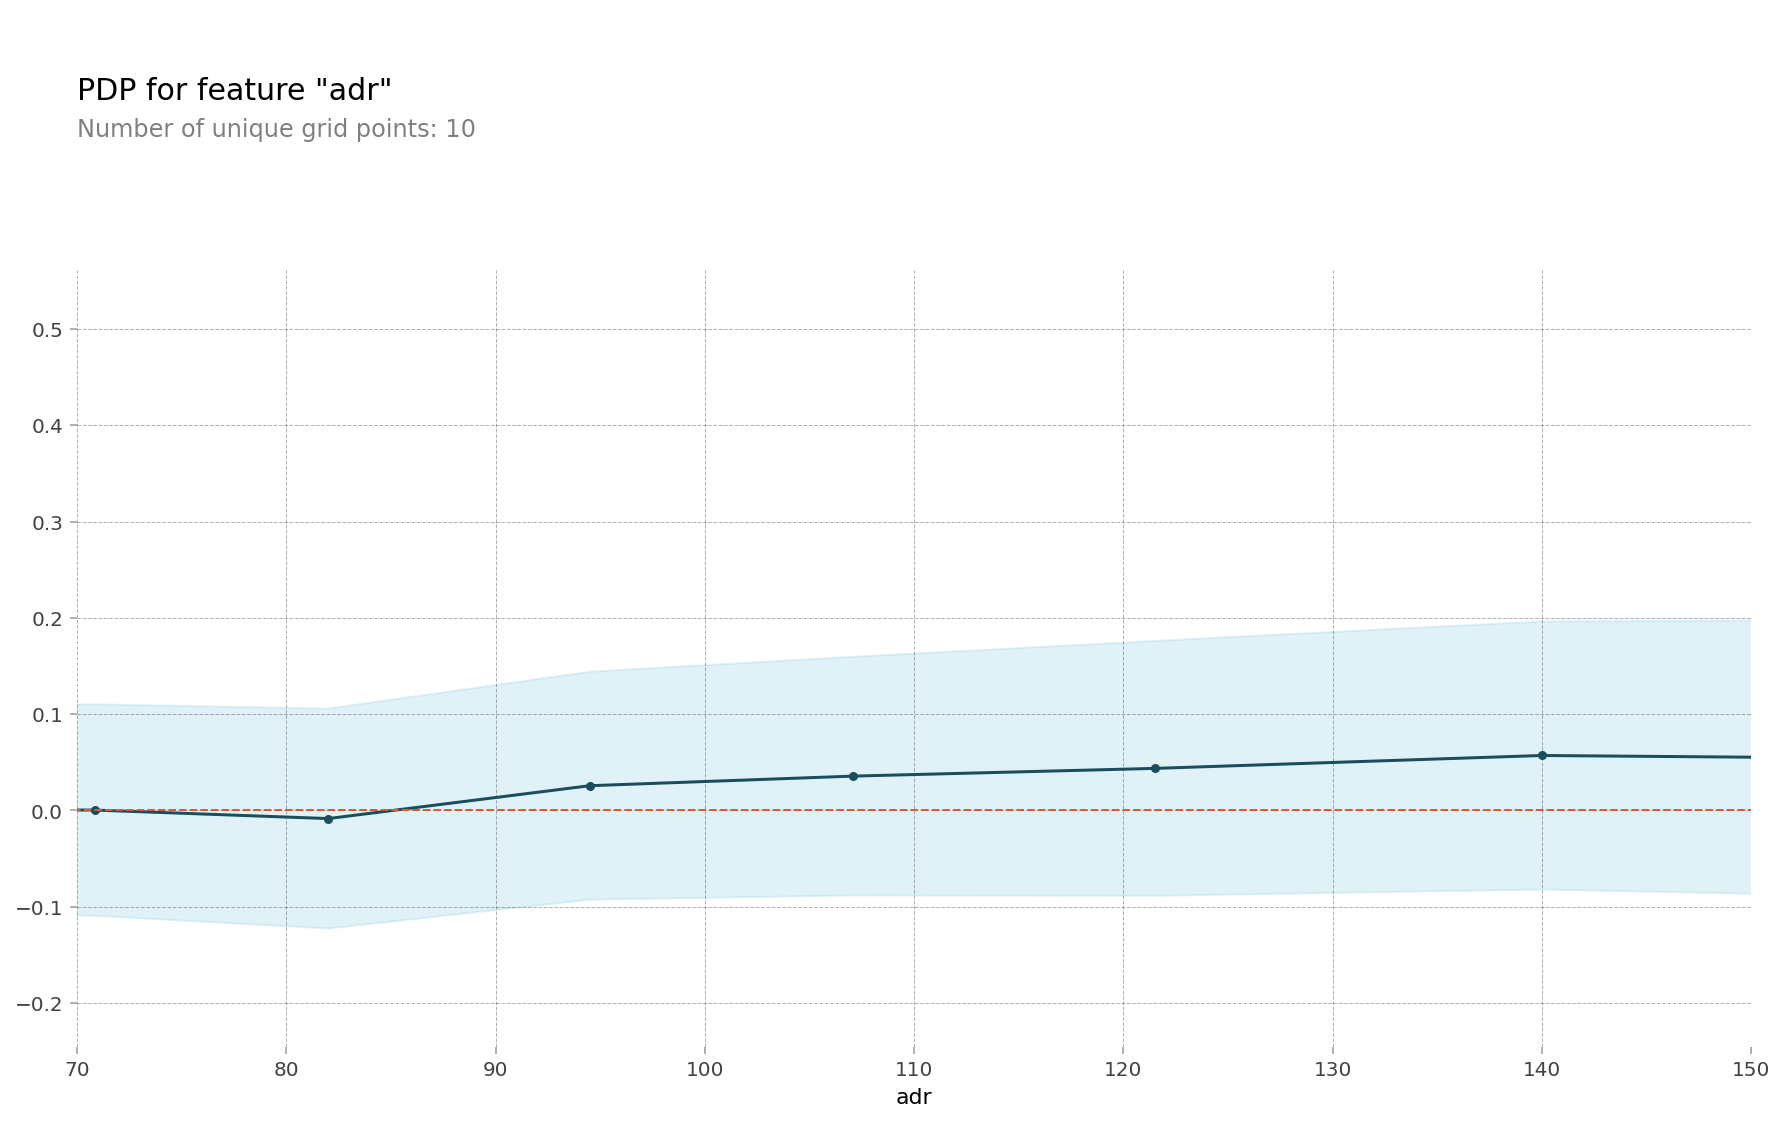

In [37]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((70,150))
plt.savefig(fname='PDP_6.png');

adr은 일 평균 숙박료를 의미하는데, 80초반까지는 취소율이 낮아지다가, 그 다음부터는 높아지는 것을 볼 수 있다. 미치는 영향은 미미하지만 적정 가격은 알 수 있다.

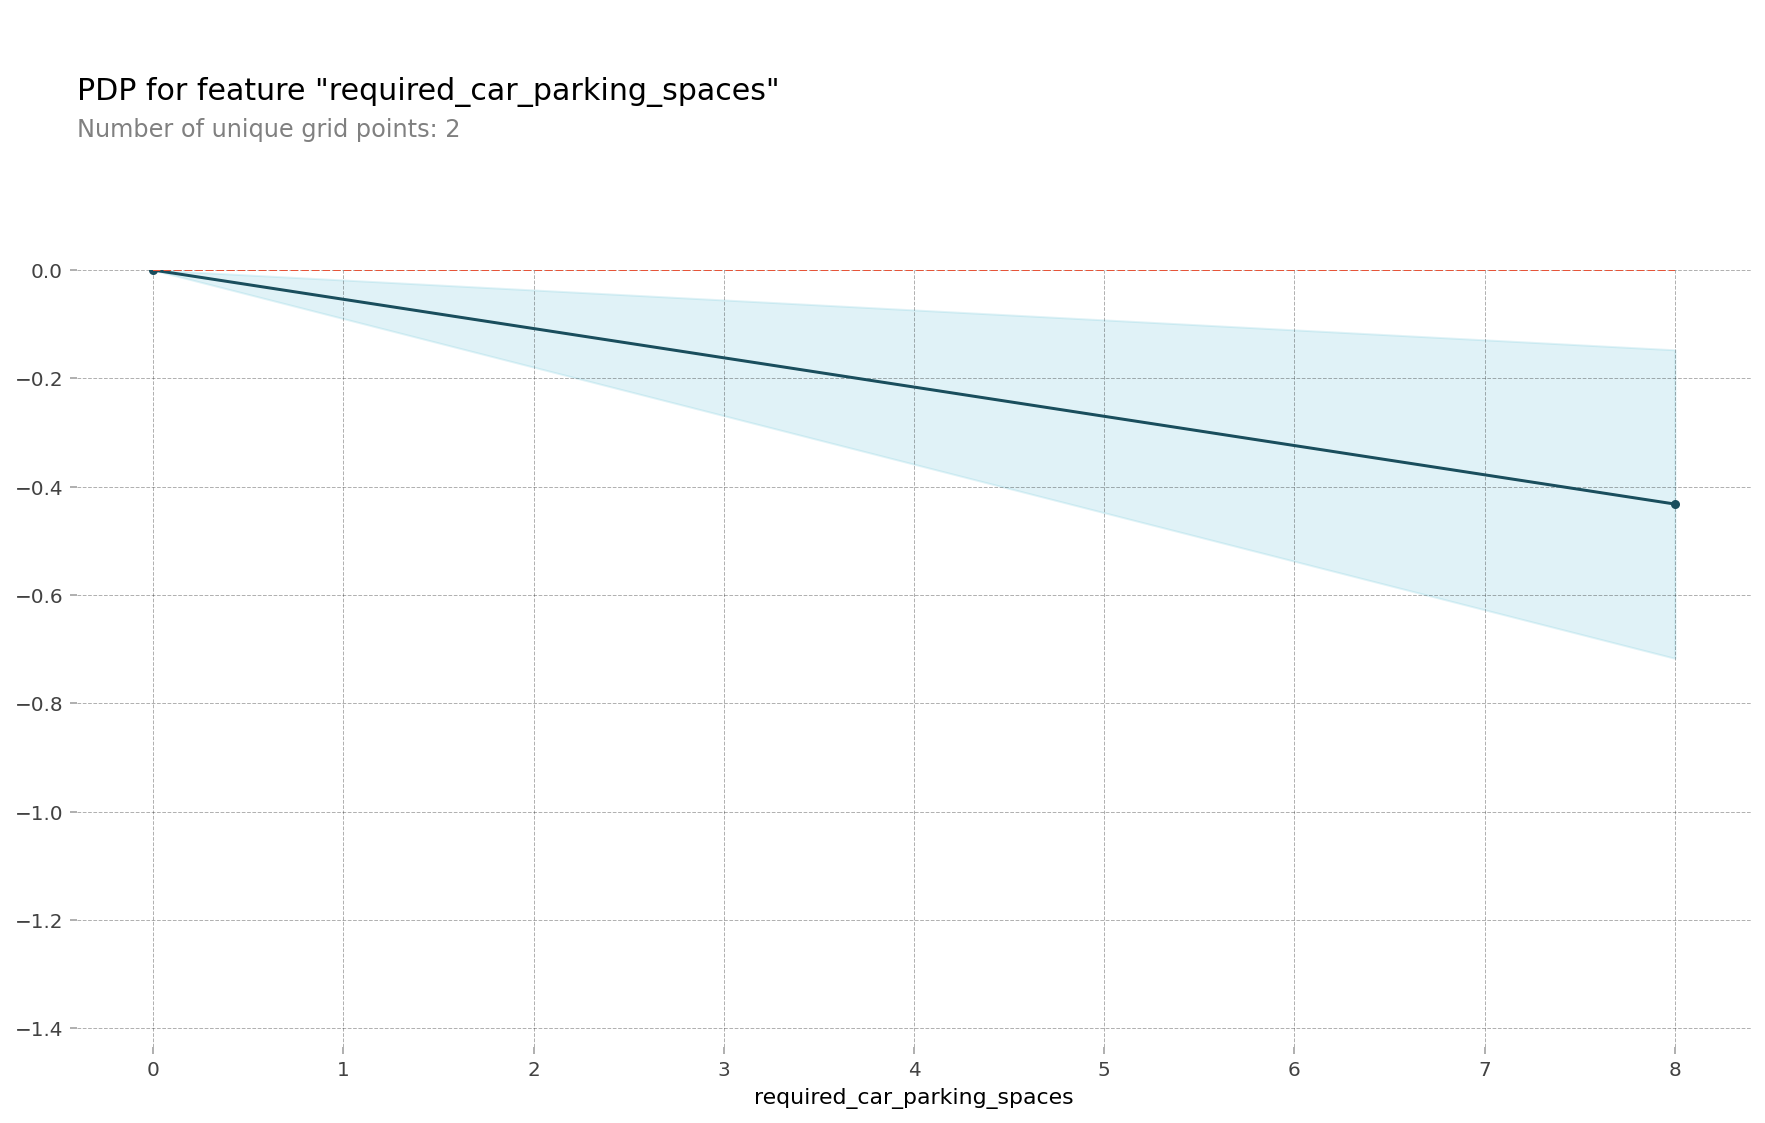

In [38]:
feature = 'required_car_parking_spaces'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)
plt.savefig(fname='PDP_8.png');

required_car_parking_spaces는 요구하는 주차공간에 대한 Feature인데 많으면 많을수록 취소정도가 낮아졌다. 예약 취소를 줄이려면 주차공간도 확보해야할 것으로 예상한다.

In [39]:
# 혹시나 방이 바뀌는 바람에 숙박료가 올라가서 많이 예약 취소한건지 알아보기 위해 2개의 특성을 사용해서 PDP 관찰
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['room_change', 'adr']

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features)

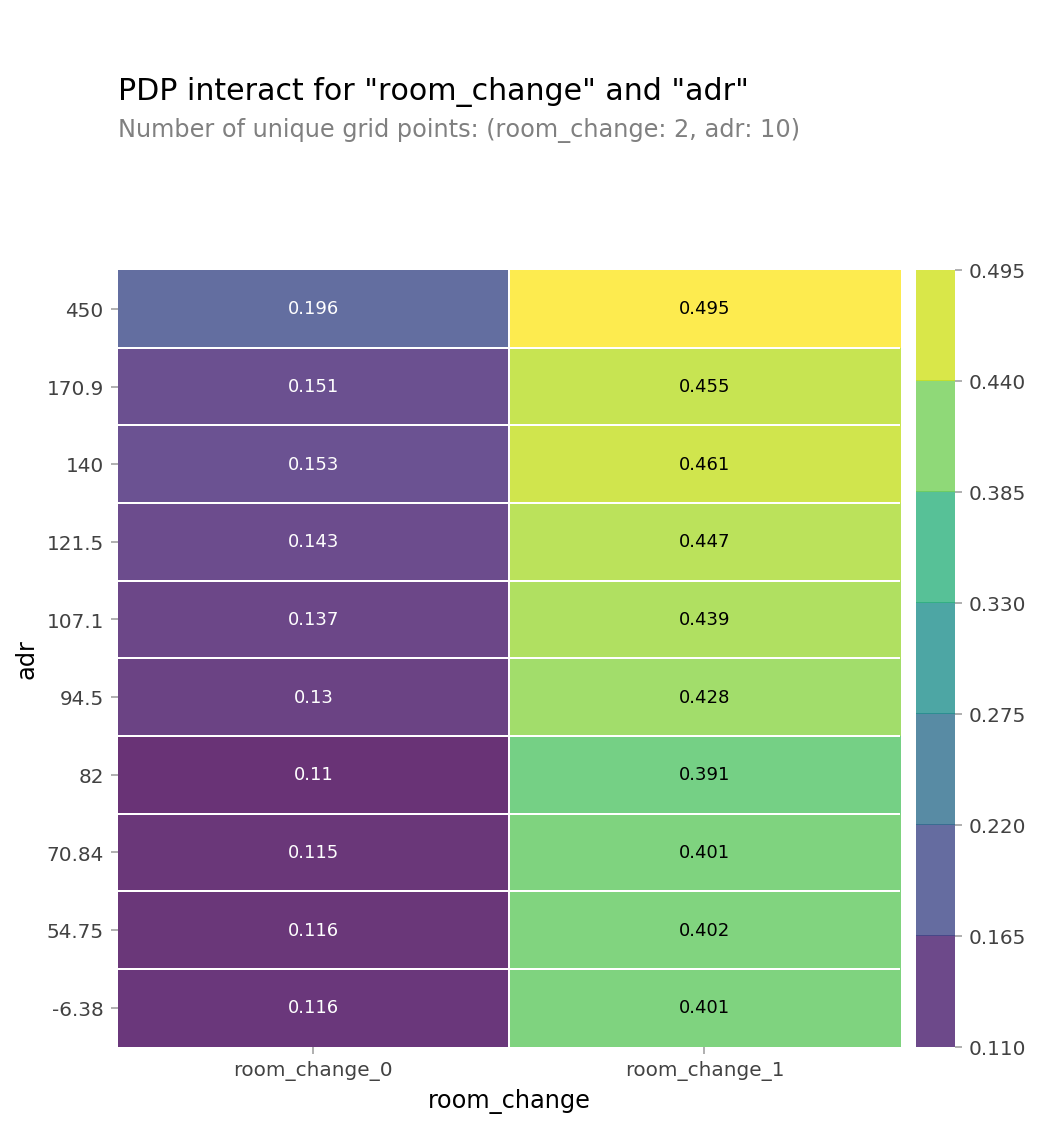

In [178]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);
plt.savefig(fname='PDP_7.png');

예상한대로 방이 바뀌고 일 평균 숙박료가 올라가면 취소하는 정도가 높아지는 것을 알 수 있다. 예약 취소를 줄이려면 일단 방이 바뀌지 않는 것이 제일 좋고, 바뀌더라도 평균 숙박료가 낮아야 한다.

In [40]:
# SHAP 그래프로 positive features와 negative features를 확인한다.
processor = make_pipeline(
    OrdinalEncoder())

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)# 검증데이터



eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=10)

[0]	validation_0-auc:0.691448	validation_1-auc:0.690604
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.691966	validation_1-auc:0.691271
[2]	validation_0-auc:0.740595	validation_1-auc:0.74137
[3]	validation_0-auc:0.741293	validation_1-auc:0.742159
[4]	validation_0-auc:0.78055	validation_1-auc:0.785807
[5]	validation_0-auc:0.796865	validation_1-auc:0.80173
[6]	validation_0-auc:0.79774	validation_1-auc:0.803285
[7]	validation_0-auc:0.80275	validation_1-auc:0.809105
[8]	validation_0-auc:0.802226	validation_1-auc:0.80835
[9]	validation_0-auc:0.805018	validation_1-auc:0.811675
[10]	validation_0-auc:0.805627	validation_1-auc:0.812535
[11]	validation_0-auc:0.810978	validation_1-auc:0.816508
[12]	validation_0-auc:0.811627	validation_1-auc:0.816939
[13]	validation_0-auc:0.812126	validation_1-auc:0.816842
[14]	validation_0-auc:0.815231	validation_1-auc:0.819492
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.7037037037037033,
              seed=None, silent=None, subsample=1, verbosity=0)

In [41]:
row = X_test.iloc[[3160]]
row

,hotel,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,room_change,blacklist
28271,Resort Hotel,285,September,39,20,2,5,2,0.0,0,BB,Groups,TA/TO,0,0,0,D,E,1,No Deposit,96.0,0,Transient-Party,78.0,0,3,2.0,0,0


In [42]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [43]:
row = X_test.iloc[[5566]]
row

,hotel,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,room_change,blacklist
31201,Resort Hotel,28,December,51,16,0,2,2,1.0,0,BB,Online TA,TA/TO,0,0,0,A,D,1,No Deposit,240.0,0,Transient,54.0,1,1,3.0,0,0


In [44]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [45]:
row = X_test.iloc[[100]]
row

,hotel,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,room_change,blacklist
7662,Resort Hotel,159,August,34,19,0,2,2,2.0,0,BB,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,240.0,0,Transient,259.0,0,0,4.0,1,0


In [46]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [76]:
obj_agent = hotel_df.groupby('agent').is_canceled.mean().sort_values(ascending=False)

In [77]:
obj_agent_df = pd.DataFrame(data=obj_agent)

obj_agent_df['is_canceled'].loc[240.0]

0.3794903285231808

In [61]:
obj_agent_df.columns

Index(['is_canceled'], dtype='object')

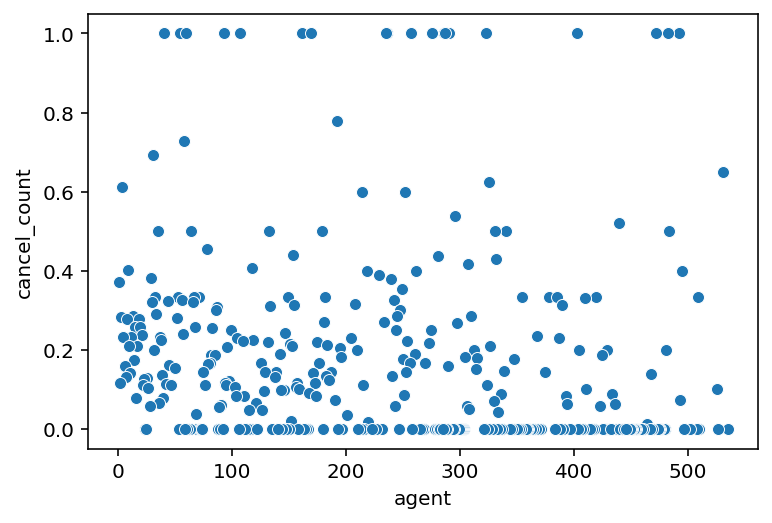

In [78]:
sns.scatterplot(x=obj_agent.index, y=obj_agent_df['is_canceled'], data=obj_agent_df);
plt.xlabel('agent')
plt.ylabel('cancel_count')
plt.savefig(fname='agent_top_10')